In [24]:
### UCI 蘑菇数据集 - Xgboost预测

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
### 查看数据的完整性，将11列的？转化为众数 

# data[11] = data[11].mode()
mode = data[11].mode()

data.loc[data[11] == '?', 11] = mode[0]
#print(data[11].mode())
#data[11]

In [4]:
### 进行数据集的切分

### x_train,x_test,y_train,y_test = train_test_split(data_x, data_y)

In [5]:
### 进行LabelEncoder

for col in data.columns:
    lbc = LabelEncoder()
    lbc.fit(data[col])
    data[col] = lbc.fit_transform(data[col])

data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [6]:
### 将数据转化成nparray
data = np.array(data)

data_y = data[:, 0]
data_x = data[:, 1:]

x_train,x_test,y_train,y_test = train_test_split(data_x, data_y)

In [7]:
### 凋整参数
### 确定 n_estimators

### 查看初始参数时的准确率
xgb_model_0 = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    ##"nthread=4,
    scale_pos_weight=1, 
    seed=0,
    nthread=-1
)

xgb_model_0.fit(x_train, y_train)

auc = accuracy_score(y_test, xgb_model_0.predict(x_test))
print("accuracy_score:"+str(auc))

dtrain = xgb.DMatrix(x_train, label=y_train)
xgb_cv = xgb.cv(params=xgb_model_0.get_params(), dtrain=dtrain, num_boost_round=1000, early_stopping_rounds=50, metrics="auc", nfold=5, show_stdv=False)
print(xgb_cv)

accuracy_score:1.0
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.994782      0.005143        0.995691       0.003971
1        0.998827      0.000343        0.998863       0.000132
2        0.999178      0.000351        0.999237       0.000377
3        0.999372      0.000404        0.999381       0.000430
4        0.999451      0.000454        0.999406       0.000450
5        0.999458      0.000376        0.999417       0.000394
6        0.999420      0.000464        0.999349       0.000519
7        0.999500      0.000459        0.999490       0.000467
8        0.999735      0.000233        0.999709       0.000294
9        0.999894      0.000130        0.999883       0.000144
10       0.999918      0.000105        0.999914       0.000118
11       0.999960      0.000068        0.999952       0.000063
12       0.999969      0.000033        0.999971       0.000028
13       0.999979      0.000025        0.999982       0.000021
14       0.999983      0.000022     

In [8]:
### 理论上上面的准确率为1不需要调优
### 调整max_depth与min_child_weight

xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    gamma= 0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    ##"nthread=4,
    scale_pos_weight=1,
    n_estimators=xgb_cv.shape[0], 
    seed=0,
    nthread=-1
)

xgb_params = {
    "max_depth":range(3, 10, 2),
    "min_child_weight":range(1, 6, 2),
}

grid = GridSearchCV(xgb_model, param_grid=xgb_params, cv=5, scoring='roc_auc')
grid.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=21,
       n_jobs=1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [9]:
print(grid.best_params_)
test_predict1 = grid.predict(x_test)

print("accuracy_score:"+str(accuracy_score(y_test, test_predict1)))

{'max_depth': 5, 'min_child_weight': 1}
accuracy_score:0.999015263417


In [10]:
### 进一步调整max_Depth与min_child_weight，进行微调

xgb_params2 = {
    "max_depth":range(4, 5, 6),
    "min_child_weight":range(1, 2),
}

grid2 = GridSearchCV(xgb_model, param_grid=xgb_params2, cv=5, scoring='roc_auc')
grid2.fit(x_train, y_train)

print(grid2.best_params_)
test_predict2 = grid2.predict(x_test)

print("accuracy_score:"+str(accuracy_score(y_test, test_predict2)))           # 在测试集上的准确率出现下滑，则不进行参数改变

{'max_depth': 4, 'min_child_weight': 1}
accuracy_score:0.995076317085


In [11]:
### 调整完毕max_depth与min_child_weight后再次进行n_estimators的调整

dtrain = xgb.DMatrix(x_train, label=y_train)
xgb_cv = xgb.cv(params=grid.best_estimator_.get_params(), dtrain=dtrain, num_boost_round=1000, early_stopping_rounds=50, metrics="auc", nfold=5, show_stdv=False)
print(xgb_cv.shape[0])

21


In [12]:
### 改变subsample与colsample_bytree

xgb_model2 = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1, 
    gamma= 0,
    objective='binary:logistic',
    ##"nthread=4,
    scale_pos_weight=1,
    n_estimators=xgb_cv.shape[0], 
    seed=0,
    nthread=-1
)

xgb_params3 = {
    "subsample":np.arange(0.3, 1, 0.1),
    "colsample_bytree":np.arange(0.3, 1, 0.1)
}

grid3 = GridSearchCV(xgb_model2, param_grid=xgb_params3, cv=5)
grid3.fit(x_train, y_train)

print(grid3.best_params_)
test_predict3 = grid3.predict(x_test)

print("accuracy_score:"+str(accuracy_score(y_test, test_predict3)))    

{'colsample_bytree': 0.80000000000000027, 'subsample': 0.90000000000000013}
accuracy_score:0.999015263417


In [13]:
### 进一步微调改变subsample与colsample_bytree

xgb_params4 = {
    "subsample":np.arange(0.8, 1, 0.05),
    "colsample_bytree":np.arange(0.5, 0.6, 0.05)
}

grid4 = GridSearchCV(xgb_model2, param_grid=xgb_params4, cv=5)
grid4.fit(x_train, y_train)

print(grid4.best_params_)
test_predict4 = grid4.predict(x_test)

print("accuracy_score:"+str(accuracy_score(y_test, test_predict4)))                       ## 达到效果为1，十分好

{'colsample_bytree': 0.5, 'subsample': 0.85000000000000009}
accuracy_score:1.0


In [14]:
### 理论上达到准确率为1不需要进行下面的调参

### 进行正则参数调整

xgb_model3 = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1, 
    colsample_bytree=0.5, 
    subsample=0.9, 
    gamma= 0,
    objective='binary:logistic',
    ##"nthread=4,
    scale_pos_weight=1,
    n_estimators=xgb_cv.shape[0], 
    seed=0,
    nthread=-1
)

xgb_params5 = {
    "reg_alpha":[0.1, 1],
    "reg_lambda":[0.5, 1, 2]
}

grid5 = GridSearchCV(xgb_model3, param_grid=xgb_params5, cv=5)
grid5.fit(x_train, y_train)

print(grid5.best_params_)
test_predict5 = grid5.predict(x_test)

print("accuracy_score:"+str(accuracy_score(y_test, test_predict5)))    

{'reg_alpha': 0.1, 'reg_lambda': 0.5}
accuracy_score:1.0


In [15]:
### 降低学习率，从0.1降到0.05，测试n_estimators的数目

xgb_model4 = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=1, 
    colsample_bytree=0.5, 
    subsample=0.9, 
    gamma= 0,
    objective='binary:logistic',
    ##"nthread=4,
    scale_pos_weight=1,
    n_estimators=xgb_cv.shape[0], 
    seed=0,
    nthread=-1, 
    reg_alpha=0.1, 
    reg_lambda=0.5
)

dtrain = xgb.DMatrix(x_train, label=y_train)
xgb_cv = xgb.cv(params=xgb_model4.get_params(), dtrain=dtrain, num_boost_round=1000, early_stopping_rounds=50, metrics="auc", nfold=5, show_stdv=False)
print(xgb_cv.shape[0])

37


In [34]:
### 得出最终的模型

xgb_model4 = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=1, 
    colsample_bytree=0.5, 
    subsample=0.9, 
    gamma= 0,
    objective='binary:logistic',
    ##"nthread=4,
    scale_pos_weight=1,
    n_estimators=xgb_cv.shape[0], 
    seed=0,
    nthread=-1, 
    reg_alpha=0.1, 
    reg_lambda=0.5, 
)

eval_set = [(x_train, y_train), (x_test, y_test)]
xgb_model_final = xgb_model4.fit(x_train, y_train, eval_set=eval_set, eval_metric=["logloss", "error"])
y_predict_final = xgb_model_final.predict(x_test)

print("调整后准确率："+str(accuracy_score(y_test, y_predict_final)))              ## 小于上面模型的概率1，则不取

[0]	validation_0-logloss:0.649421	validation_0-error:0.030199	validation_1-logloss:0.649854	validation_1-error:0.033481
[1]	validation_0-logloss:0.614226	validation_0-error:0.037912	validation_1-logloss:0.615077	validation_1-error:0.037912
[2]	validation_0-logloss:0.577454	validation_0-error:0.017233	validation_1-logloss:0.578418	validation_1-error:0.019202
[3]	validation_0-logloss:0.542747	validation_0-error:0.015756	validation_1-logloss:0.54369	validation_1-error:0.017725
[4]	validation_0-logloss:0.512235	validation_0-error:0.017561	validation_1-logloss:0.512778	validation_1-error:0.018218
[5]	validation_0-logloss:0.480033	validation_0-error:0.010176	validation_1-logloss:0.480573	validation_1-error:0.010832
[6]	validation_0-logloss:0.451998	validation_0-error:0.006073	validation_1-logloss:0.452465	validation_1-error:0.005416
[7]	validation_0-logloss:0.425903	validation_0-error:0.007057	validation_1-logloss:0.426217	validation_1-error:0.006401
[8]	validation_0-logloss:0.403148	validat

In [35]:
### 画出学习曲线

eval_result = xgb_model_final.evals_result()
print(eval_result)

{'validation_0': {'logloss': [0.649421, 0.614226, 0.577454, 0.542747, 0.512235, 0.480033, 0.451998, 0.425903, 0.403148, 0.384754, 0.36363, 0.342662, 0.325155, 0.307009, 0.291485, 0.278821, 0.264037, 0.250206, 0.237179, 0.226138, 0.214516, 0.203763, 0.193799, 0.185476, 0.175743, 0.16701, 0.159193, 0.151834, 0.146239, 0.138861, 0.132282, 0.126996, 0.12129, 0.116795, 0.110928, 0.106577, 0.101275], 'error': [0.030199, 0.037912, 0.017233, 0.015756, 0.017561, 0.010176, 0.006073, 0.007057, 0.006073, 0.006073, 0.007057, 0.006073, 0.006073, 0.007057, 0.004924, 0.007057, 0.004924, 0.004924, 0.004924, 0.004924, 0.004924, 0.004924, 0.003939, 0.003939, 0.001969, 0.001969, 0.002626, 0.003939, 0.003939, 0.002626, 0.001969, 0.001969, 0.001969, 0.001969, 0.000985, 0.001969, 0.000985]}, 'validation_1': {'logloss': [0.649854, 0.615077, 0.578418, 0.54369, 0.512778, 0.480573, 0.452465, 0.426217, 0.403549, 0.385517, 0.36411, 0.343156, 0.325692, 0.307452, 0.292151, 0.279564, 0.26477, 0.250792, 0.237765, 0.22

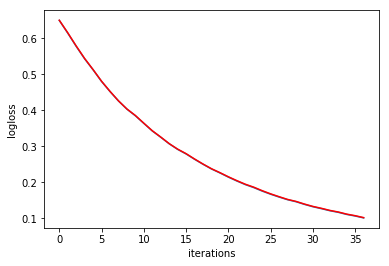

In [36]:
### 画出logloss与error图
x = range(0, len(eval_result["validation_0"]['logloss']))
plt.plot(x, eval_result["validation_0"]['logloss'])
plt.plot(x, eval_result["validation_1"]['logloss'], color='r')
plt.xlabel("iterations")
plt.ylabel("logloss")
plt.show()

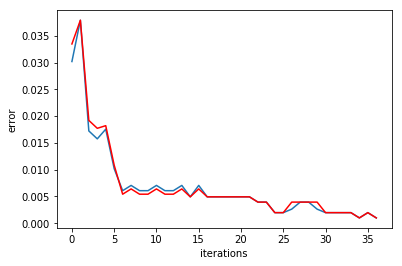

In [37]:
### 画error图 

x2 = range(0, len(eval_result["validation_0"]['error']))
plt.plot(x2, eval_result["validation_0"]['error'])
plt.plot(x2, eval_result["validation_1"]['error'], color='r')
plt.xlabel("iterations")
plt.ylabel("error")
plt.show()